

The ReBlurSR dataset is designed for real-world blurred image super-resolution, containing high-resolution (HR, sharp) and low-resolution (LR, blurred) images with defocus and motion blur types. 
the file is 15.68 GB , with almost 3000 HR pictures 

what it contains : 
1. ALL_HR : High resolution (sharp) images 
2. ALL_mask : corresponding blur masks 
3. valid/defocus/LR/X4/, valid/motion/LR/X4/: Low-resolution (blurred) images
4. .npy files : 
    - train_validation_class.npy: Labels images as train (0) or validation (1).
    - defocus_motion_class.npy: Labels blur type as defocus (0) or motion (1).        

Think of .npy files as label sheets for a box of photos:

- Each photo (image in ALL_HR) has a sticky note with two labels:
    - One says “train” or “validation” (train_validation_class.npy).
    - Another says “defocus” or “motion” (defocus_motion_class.npy).
    


In [87]:
import os
import glob
import shutil
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
defocus_lr_dir = '/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/valid/defocus/LR/X4'
motion_lr_dir = '/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/valid/motion/LR/X4'

In [48]:
hr_dir = '/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/all_HR'
output_dir = "/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/subset_dataset"
os.makedirs(os.path.join(output_dir,"blurred"),exist_ok=True)
os.makedirs(os.path.join(output_dir,"clear"),exist_ok=True)



In [49]:
defocus_lr_images = [f for f in os.listdir(defocus_lr_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
motion_lr_images = [f for f in os.listdir(motion_lr_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
hr_images = [f for f in os.listdir(hr_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [50]:
selected_defocus = random.sample(defocus_lr_images, 250)
selected_motion = random.sample(motion_lr_images, 250)
selected_blurred = selected_defocus + selected_motion

selected_clear = random.sample(hr_images, 500)

In [51]:
len(selected_clear)

500

In [55]:

for img in tqdm(selected_blurred):
    src = os.path.join(defocus_lr_dir if img in selected_defocus else motion_lr_dir, img)
    shutil.copy(src, os.path.join(output_dir, "blurred", img))


for img in tqdm(selected_clear):
    src = os.path.join(hr_dir, img)
    shutil.copy(src, os.path.join(output_dir, "clear", img))

100%|██████████| 500/500 [02:48<00:00,  2.97it/s] 


In [56]:
import pandas as pd
metadata = []
for img in os.listdir(os.path.join(output_dir, "blurred")):
    metadata.append({"filename": os.path.join("blurred", img), "label": 1})
for img in os.listdir(os.path.join(output_dir, "clear")):
    metadata.append({"filename": os.path.join("clear", img), "label": 0})
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)

In [57]:
metadata

[{'filename': 'blurred/DIV2K_0853_0005_LRx4.png', 'label': 1},
 {'filename': 'blurred/motion0082_0005_LRx4.png', 'label': 1},
 {'filename': 'blurred/motion0082_0004_LRx4.png', 'label': 1},
 {'filename': 'blurred/out_of_focus0061_0003_LRx4.png', 'label': 1},
 {'filename': 'blurred/EBD_1479_0005_LRx4.png', 'label': 1},
 {'filename': 'blurred/EBD_1485_0006_LRx4.png', 'label': 1},
 {'filename': 'blurred/out_of_focus0037_0001_LRx4.png', 'label': 1},
 {'filename': 'blurred/motion0288_0007_LRx4.png', 'label': 1},
 {'filename': 'blurred/DIV2K_0805_0007_LRx4.png', 'label': 1},
 {'filename': 'blurred/motion0224_0003_LRx4.png', 'label': 1},
 {'filename': 'blurred/EBD_1483_0003_LRx4.png', 'label': 1},
 {'filename': 'blurred/motion0224_0002_LRx4.png', 'label': 1},
 {'filename': 'blurred/out_of_focus0067_0007_LRx4.png', 'label': 1},
 {'filename': 'blurred/out_of_focus0019_0001_LRx4.png', 'label': 1},
 {'filename': 'blurred/out_of_focus0019_0000_LRx4.png', 'label': 1},
 {'filename': 'blurred/out_of_f

In [58]:
test = pd.DataFrame(metadata)

In [59]:
test.shape

(1000, 2)

In [60]:
len(metadata)

1000

In [61]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/subset_dataset/metadata.csv")

print("Total images:", len(df))
print("Blurred:", len(df[df["label"] == 1]), "Clear:", len(df[df["label"] == 0]))


Total images: 1000
Blurred: 500 Clear: 500


In [62]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)

In [63]:
# Split temp into validation (50% of temp = 15% of total) and test (50% of temp = 15% of total)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [64]:
train_df.to_csv("/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/subset_dataset/train_metadata.csv", index=False)
val_df.to_csv("/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/subset_dataset/val_metadata.csv", index=False)
test_df.to_csv("/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/subset_dataset/test_metadata.csv", index=False)

In [65]:
print("Training set:", len(train_df), "images")
print("Validation set:", len(val_df), "images")
print("Test set:", len(test_df), "images")

Training set: 700 images
Validation set: 150 images
Test set: 150 images


init for loading the csv, dir, and transform 
len for the nubmer of the smaples 
getitem for getting the image and its index

In [80]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class BlurDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):# constructor 
        path = os.path.join(root_dir,csv_file)
        self.metadata = pd.read_csv(path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx): # image and its label 
        img_name = os.path.join(self.root_dir, self.metadata.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.metadata.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

Resize all images to 224x224 (this is the standard size for ResNet18).

Convert images to PyTorch tensors.

Normalize the images to [-1, 1] range (because mean = 0.5 and std = 0.5).

In [83]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),      
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  
])

shuffle=True for training, which is important for better learning.

shuffle=False for validation and testing (normal).

DataLoader in PyTorch is a tool that helps you:
- Automatically load the data in small batches (not one by one).
- Shuffle the data (mix it randomly for training).
- Feed batches to the model during training, validation, and testing.
- Make loading faster (parallel loading if needed — not very important on M2, but still good).

In [84]:
from torch.utils.data import DataLoader
root_dir="/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/subset_dataset"
train_dataset = BlurDataset(csv_file='train_metadata.csv', root_dir=root_dir, transform=transform)
val_dataset = BlurDataset(csv_file='val_metadata.csv', root_dir=root_dir, transform=transform)
test_dataset = BlurDataset(csv_file='test_metadata.csv', root_dir=root_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False)
# In validation and testing, you dont shuffle because you want to measure real performance.


took a ResNet18 that is already pretrained on ImageNet 
The orginal ResNet has 1000 ouputs (for 1000 ImageNet classes )


In [85]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class BlurDetectionModel(nn.Module):
    def __init__(self):
        super(BlurDetectionModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  # Replace the final fc (fully connected layer) to output 2  (blurred/not blurred)

    def forward(self, x):
        return self.resnet(x)

7*7*64*3 + 64 

In [111]:
resnet = resnet18(pretrained=True)
resnet

/opt/homebrew/Caskroom/miniforge/base/envs/computervision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/computervision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [98]:
# flexing my device capabilites 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')



Using device: mps


In [93]:
model = BlurDetectionModel().to(device)


/opt/homebrew/Caskroom/miniforge/base/envs/computervision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/computervision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/masaaladwan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:11<00:00, 4.13MB/s]


In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [95]:
num_epochs = 10


In [96]:

# Training and Validation

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad() # clear the previous gradients
        outputs = model(images) # forward pass 
        loss = criterion(outputs, labels)
        loss.backward() # backprogoagtion 
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% '
          f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')



Epoch [1/10] Train Loss: 0.5119 | Train Acc: 84.71% | Val Loss: 2.7018 | Val Acc: 48.00%
Epoch [2/10] Train Loss: 0.1001 | Train Acc: 96.71% | Val Loss: 0.7112 | Val Acc: 83.33%
Epoch [3/10] Train Loss: 0.1169 | Train Acc: 95.29% | Val Loss: 0.4215 | Val Acc: 88.00%
Epoch [4/10] Train Loss: 0.0816 | Train Acc: 96.57% | Val Loss: 0.1407 | Val Acc: 94.00%
Epoch [5/10] Train Loss: 0.1138 | Train Acc: 95.86% | Val Loss: 0.1442 | Val Acc: 93.33%
Epoch [6/10] Train Loss: 0.0853 | Train Acc: 97.29% | Val Loss: 0.2544 | Val Acc: 89.33%
Epoch [7/10] Train Loss: 0.0674 | Train Acc: 97.57% | Val Loss: 0.1372 | Val Acc: 94.67%
Epoch [8/10] Train Loss: 0.0405 | Train Acc: 98.71% | Val Loss: 0.8317 | Val Acc: 82.00%
Epoch [9/10] Train Loss: 0.0602 | Train Acc: 97.86% | Val Loss: 0.2677 | Val Acc: 93.33%
Epoch [10/10] Train Loss: 0.0347 | Train Acc: 98.71% | Val Loss: 0.1017 | Val Acc: 94.67%



Classification Report:
              precision    recall  f1-score   support

       Clear       0.99      0.95      0.97        75
     Blurred       0.95      0.99      0.97        75

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



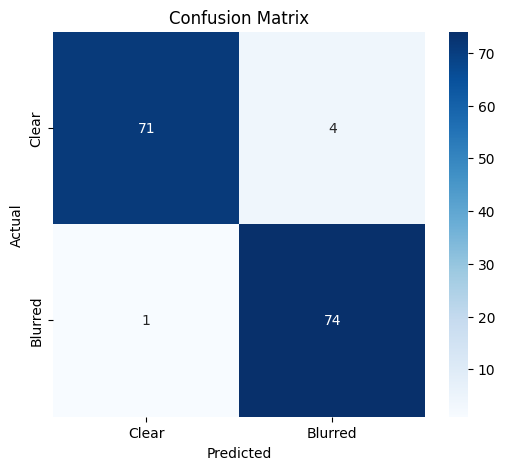

In [97]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['Clear', 'Blurred'])

print("\nClassification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clear', 'Blurred'], yticklabels=['Clear', 'Blurred'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [99]:
torch.save(model.state_dict(), 'blur_detection_model.pth')

# Skipped 


In [4]:
# i will start with reducing the dataset size 
data_dir = '/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR'

image_paths = sorted(glob.glob(f'{data_dir}/ALL_HR/*.png'))
mask_paths = sorted(glob.glob(f'{data_dir}/ALL_mask/*.png'))
lr_defocus = sorted(glob.glob(f'{data_dir}/valid/defocus/LR/X4/*.png'))
lr_motion = sorted(glob.glob(f'{data_dir}/valid/motion/LR/X4/*.png'))

print(f'HR Images: {len(image_paths)}')
print(f'Masks: {len(mask_paths)}')
print(f'LR Defocus: {len(lr_defocus)}')
print(f'LR Motion: {len(lr_motion)}')

HR Images: 2393
Masks: 2718
LR Defocus: 800
LR Motion: 400


these is smth wrong, lets check the formats

In [9]:
#multiple formats
image_paths = sorted(glob.glob(f'{data_dir}/ALL_HR/*.*'))
mask_paths = sorted(glob.glob(f'{data_dir}/ALL_mask/*.*'))
lr_defocus = sorted(glob.glob(f'{data_dir}/valid/defocus/LR/X4/*.*'))
lr_motion = sorted(glob.glob(f'{data_dir}/valid/motion/LR/X4/*.*'))

def count_formats(paths):
    formats = {}
    for p in paths:
        # function thats split the path into root and extension 
        # https://www.geeksforgeeks.org/python-os-path-splitext-method/
        ext = os.path.splitext(p)[1].lower()  # e.g., .png, .jpg
        formats[ext] = formats.get(ext, 0) + 1
    return formats

print(f'HR Images: {len(image_paths)}')
print(f'HR Formats: {count_formats(image_paths)}')
print("--"*50)

print(f'Masks: {len(mask_paths)}')
print(f'Mask Formats: {count_formats(mask_paths)}')
print("--"*50)

print(f'LR Defocus: {len(lr_defocus)}')
print(f'LR Defocus Formats: {count_formats(lr_defocus)}')
print("--"*50)

print(f'LR Motion: {len(lr_motion)}')
print(f'LR Motion Formats: {count_formats(lr_motion)}')
print("--"*50)

train_valid_class = np.load('/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/train_validation_class.npy') 
defocus_motion_class = np.load(f'/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR/defocus_motion_class.npy')


HR Images: 2931
HR Formats: {'.png': 2393, '.jpg': 538}
----------------------------------------------------------------------------------------------------
Masks: 2931
Mask Formats: {'.png': 2718, '.jpg': 213}
----------------------------------------------------------------------------------------------------
LR Defocus: 800
LR Defocus Formats: {'.png': 800}
----------------------------------------------------------------------------------------------------
LR Motion: 400
LR Motion Formats: {'.png': 400}
----------------------------------------------------------------------------------------------------


In [10]:

print(f'Total Images in .npy: {len(train_valid_class)}')
print(f'Train (0): {np.sum(train_valid_class == 0)}, Valid (1): {np.sum(train_valid_class == 1)}')
print(f'Defocus (0): {np.sum(defocus_motion_class == 0)}, Motion (1): {np.sum(defocus_motion_class == 1)}')

Total Images in .npy: 2931
Train (0): 2811, Valid (1): 120
Defocus (0): 2566, Motion (1): 365


the problems :
1. the validation is 4% of the whole data 
2. defocus outnumbers motion, so the subset mist balance these to aviode bias 


 to reduce the dataset : 
 select 1000 HR images and 200 LR, but : 
 - the train/vaild/test will be 80/10/10 
 - the format is mixed and its okay for now 
 - im not sure how to deal with defocus. motion 

In [15]:
# Subset HR images
np.random.seed(42)
subset_size = 1000

defocus_indices = np.where(defocus_motion_class == 0)[0]  # 2566
motion_indices = np.where(defocus_motion_class == 1)[0]   # 365


In [24]:

defocus_subset = np.random.choice(defocus_indices, size=int(0.80 * subset_size), replace=False) 
motion_subset = np.random.choice(motion_indices, size=int(0.20 * subset_size), replace=False)  

subset_indices = np.concatenate([defocus_subset, motion_subset])

np.random.shuffle(subset_indices)

print(defocus_subset.size)
print(motion_subset.size)
print(subset_indices.size)

800
200
1000


In [25]:

image_paths_subset = [image_paths[i] for i in subset_indices]

train_valid_class_subset = train_valid_class[subset_indices]

defocus_motion_class_subset = defocus_motion_class[subset_indices]


In [33]:

# Adjust train/valid split (since valid is small)
valid_subset_indices = np.where(train_valid_class_subset == 1)[0]  
train_subset_indices = np.where(train_valid_class_subset == 0)[0]
print(train_subset_indices.size)
print(valid_subset_indices.size)

800
200


In [34]:
if len(valid_subset_indices) < 200:
    extra_valid = np.random.choice(train_subset_indices, size=200 - len(valid_subset_indices), replace=False)
    train_valid_class_subset[extra_valid] = 1
    valid_subset_indices = np.where(train_valid_class_subset == 1)[0]
    train_subset_indices = np.where(train_valid_class_subset == 0)[0]

In [35]:
print(f'Adjusted Subset Train (0): {len(train_subset_indices)}')
print(f'Adjusted Subset Valid (1): {len(valid_subset_indices)}')
print(f'Subset HR Images: {len(image_paths_subset)}')
print(f'Subset Defocus (0): {np.sum(defocus_motion_class_subset == 0)}')
print(f'Subset Motion (1): {np.sum(defocus_motion_class_subset == 1)}')

Adjusted Subset Train (0): 800
Adjusted Subset Valid (1): 200
Subset HR Images: 1000
Subset Defocus (0): 880
Subset Motion (1): 120


In [36]:
data_dir = os.path.expanduser('/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR')
output_dir = os.path.expanduser('/Users/masaaladwan/Desktop/Leading point /ComputerVision/BlurDataset') 
os.makedirs(output_dir, exist_ok=True)

In [37]:
image_paths = sorted(glob.glob(f'{data_dir}/ALL_HR/*.*'))
train_valid_class = np.load(f'{data_dir}/train_validation_class.npy')
defocus_motion_class = np.load(f'{data_dir}/defocus_motion_class.npy')

In [42]:
np.random.seed(42)
subset_size = 1000
defocus_indices = np.where(defocus_motion_class == 0)[0]
motion_indices = np.where(defocus_motion_class == 1)[0]
defocus_subset = np.random.choice(defocus_indices, size=int(0.80 * subset_size), replace=False)
motion_subset = np.random.choice(motion_indices, size=int(0.20 * subset_size), replace=False)
subset_indices = np.concatenate([defocus_subset, motion_subset])
np.random.shuffle(subset_indices)

image_paths_subset = [image_paths[i] for i in subset_indices]
train_valid_class_subset = train_valid_class[subset_indices]
valid_subset_indices = np.where(train_valid_class_subset == 1)[0]
train_subset_indices = np.where(train_valid_class_subset == 0)[0]
if len(valid_subset_indices) < 200:
    extra_valid = np.random.choice(train_subset_indices, size=200 - len(valid_subset_indices), replace=False)
    train_valid_class_subset[extra_valid] = 1
defocus_motion_class_subset = defocus_motion_class[subset_indices]

In [43]:
for split in ['train', 'valid']:
    for blur_type in ['defocus', 'motion']:
        os.makedirs(f'{split}/{blur_type}/HR', exist_ok=True)

In [44]:
for i in tqdm(range(len(image_paths_subset)), desc="Linking HR Images"):
    img_name = os.path.basename(image_paths_subset[i])
    src_img = os.path.abspath(image_paths_subset[i])
    try:
        if train_valid_class_subset[i] == 0:  # Train
            if defocus_motion_class_subset[i] == 0:  # Defocus
                os.symlink(src_img, f'train/defocus/HR/{img_name}')
            else:  # Motion
                os.symlink(src_img, f'train/motion/HR/{img_name}')
        else:  # Validation
            if defocus_motion_class_subset[i] == 0:  # Defocus
                os.symlink(src_img, f'valid/defocus/HR/{img_name}')
            else:  # Motion
                os.symlink(src_img, f'valid/motion/HR/{img_name}')
    except FileExistsError:
        pass  # Skip if symlink exists

Linking HR Images: 100%|██████████| 1000/1000 [00:00<00:00, 19816.51it/s]


In [45]:
print(f'Train Defocus HR: {len(glob.glob("train/defocus/HR/*.*"))}')
print(f'Train Motion HR: {len(glob.glob("train/motion/HR/*.*"))}')
print(f'Valid Defocus HR: {len(glob.glob("valid/defocus/HR/*.*"))}')
print(f'Valid Motion HR: {len(glob.glob("valid/motion/HR/*.*"))}')

Train Defocus HR: 843
Train Motion HR: 168
Valid Defocus HR: 276
Valid Motion HR: 71


# Splitting the data to Train , valid , Test 

 This script splits the ReBlurSR dataset into train, validation, and test sets for a blur detection model (sharp vs. blurred). It adapts the original train_validation_split.py to organize high-resolution (HR, sharp) and low-resolution (LR, blurred) images into a BlurDataset structure.

In [2]:
import os
import glob
import shutil
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
data_dir = '/Users/masaaladwan/Desktop/Leading point /ComputerVision/ReBlurSR'  
output_dir = '/Users/masaaladwan/Desktop/Leading point /ComputerVision/BlurDataset'   


In [ ]:
train_valid_class = np.load(f'{data_dir}/train_validation_class.npy')
defocus_motion_class = np.load(f'{data_dir}/defocus_motion_class.npy')

# Print shapes and unique values to understand the data
print(f'Train/Valid Classes: {train_valid_class.shape}, Values: {np.unique(train_valid_class)}')
print(f'Defocus/Motion Classes: {defocus_motion_class.shape}, Values: {np.unique(defocus_motion_class)}')

In [ ]:
train_valid_class

In [ ]:
print(np.bincount(train_valid_class))  # Counts of 0 (train) and 1 (validation)

Think of .npy files as label sheets for a box of photos:

Each photo (image in ALL_HR) has a sticky note with two labels:
One says “train” or “validation” (train_validation_class.npy).
Another says “defocus” or “motion” (defocus_motion_class.npy).
The script reads these labels to sort photos into folders (train/defocus, valid/motion, etc.).
For your blur detection, you’re using these labels to decide which photos are “sharp” (HR) and which are “blurred” (LR or synthetic), then organizing them into BlurDataset.

In [ ]:
# Step 3: Collect image paths
# Use glob to get sorted lists of HR images and masks
image_paths = sorted(glob.glob(f'{data_dir}/ALL_HR/*'))
mask_paths = sorted(glob.glob(f'{data_dir}/ALL_mask/*'))

In [ ]:
print(f'HR Images: {len(image_paths)}')
print(f'Masks: {len(mask_paths)}')
assert len(image_paths) == len(mask_paths) == len(train_valid_class), 'Mismatch in file counts!'

In [ ]:
# Set up folders for original train/valid (HR and masks) and BlurDataset for classification
os.makedirs('train/defocus/HR', exist_ok=True)
os.makedirs('train/defocus/mask', exist_ok=True)
os.makedirs('train/motion/HR', exist_ok=True)
os.makedirs('train/motion/mask', exist_ok=True)
os.makedirs('valid/defocus/HR', exist_ok=True)
os.makedirs('valid/defocus/mask', exist_ok=True)
os.makedirs('valid/motion/HR', exist_ok=True)
os.makedirs('valid/motion/mask', exist_ok=True)

In [ ]:
os.makedirs(f'{output_dir}/train/sharp', exist_ok=True)
os.makedirs(f'{output_dir}/train/blurred', exist_ok=True)
os.makedirs(f'{output_dir}/val/sharp', exist_ok=True)
os.makedirs(f'{output_dir}/val/blurred', exist_ok=True)
os.makedirs(f'{output_dir}/test/sharp', exist_ok=True)
os.makedirs(f'{output_dir}/test/blurred', exist_ok=True)

In [ ]:
# Step 5: Split and copy HR images and masks
# Copy HR images and masks to train or valid based on train_valid_class and defocus_motion_class


In [ ]:
for i in tqdm(range(len(image_paths)), desc="Splitting HR and masks"):
    img_name = os.path.basename(image_paths[i])
    mask_name = os.path.basename(mask_paths[i])

    if train_valid_class[i] == 0:  # Train
        if defocus_motion_class[i] == 0:  # Defocus
            shutil.copy(image_paths[i], f'train/defocus/HR/{img_name}')
            shutil.copy(mask_paths[i], f'train/defocus/mask/{mask_name}')
        else:  # Motion
            shutil.copy(image_paths[i], f'train/motion/HR/{img_name}')
            shutil.copy(mask_paths[i], f'train/motion/mask/{mask_name}')
            
    else:  # Validation
        if defocus_motion_class[i] == 0:  # Defocus
            shutil.copy(image_paths[i], f'valid/defocus/HR/{img_name}')
            shutil.copy(mask_paths[i], f'valid/defocus/mask/{mask_name}')
        else:  # Motion
            shutil.copy(image_paths[i], f'valid/motion/HR/{img_name}')
            shutil.copy(mask_paths[i], f'valid/motion/mask/{mask_name}')

whats the tqdm , it python library that adds a progress bat to loops showing how much work is done 

In [ ]:
# Step 6: Create BlurDataset for classification
# Organize HR (sharp) and LR (blurred) images into BlurDataset
# Split valid into validation and test sets
# Use synthetic blur for train/blurred (handled later in PyTorch dataset)

train_sharp = list(Path('train/defocus/HR').glob('*.png')) + \
              list(Path('train/motion/HR').glob('*.png'))

valid_sharp = list(Path('valid/defocus/HR').glob('*.png')) + \
              list(Path('valid/motion/HR').glob('*.png'))

blurred = list(Path(f'{data_dir}/valid/defocus/LR/X4').glob('*.png')) + \
          list(Path(f'{data_dir}/valid/motion/LR/X4').glob('*.png'))

BlurDataset/
├── train/
│   ├── sharp/    # Images from train_sharp
│   └── blurred/  # Empty, synthetic blur added later
├── val/
│   ├── sharp/    # Half of valid_sharp
│   └── blurred/  # Half of blurred
├── test/
│   ├── sharp/    # Half of valid_sharp
│   └── blurred/  # Half of blurred

In [ ]:
# Shuffle and split valid images into val and test
np.random.seed(42)
np.random.shuffle(valid_sharp)
np.random.shuffle(blurred)
val_sharp = valid_sharp[:len(valid_sharp)//2]
test_sharp = valid_sharp[len(valid_sharp)//2:]
val_blurred = blurred[:len(blurred)//2]
test_blurred = blurred[len(blurred)//2:]


In [ ]:
# Copy to BlurDataset
for img in tqdm(train_sharp, desc="Copying train sharp"):
    shutil.copy(img, f'{output_dir}/train/sharp/{img.name}')
for img in tqdm(val_sharp, desc="Copying val sharp"):
    shutil.copy(img, f'{output_dir}/val/sharp/{img.name}')
for img in tqdm(test_sharp, desc="Copying test sharp"):
    shutil.copy(img, f'{output_dir}/test/sharp/{img.name}')
for img in tqdm(val_blurred, desc="Copying val blurred"):
    shutil.copy(img, f'{output_dir}/val/blurred/{img.name}')
for img in tqdm(test_blurred, desc="Copying test blurred"):
    shutil.copy(img, f'{output_dir}/test/blurred/{img.name}')
    
print('BlurDataset created!')

In [ ]:
# Step 7: Verify the split
# Check the number of images in each folder to ensure the split is balanced
def count_images(folder):
    return len(list(Path(folder).glob('*.png')))

print('Train Sharp:', count_images(f'{output_dir}/train/sharp'))
print('Train Blurred:', count_images(f'{output_dir}/train/blurred'))
print('Val Sharp:', count_images(f'{output_dir}/val/sharp'))
print('Val Blurred:', count_images(f'{output_dir}/val/blurred'))
print('Test Sharp:', count_images(f'{output_dir}/test/sharp'))
print('Test Blurred:', count_images(f'{output_dir}/test/blurred'))

In [ ]:
# Step 8: Visualize sample images
# Display a sharp and blurred image to confirm the dataset
sharp_img = Image.open(next(Path(f'{output_dir}/val/sharp').glob('*.png')))
blurred_img = Image.open(next(Path(f'{output_dir}/val/blurred').glob('*.png')))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sharp_img)
plt.title('Sharp')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blurred_img)
plt.title('Blurred')
plt.axis('off')
plt.savefig(f'{output_dir}/sample_images.png')  # Save plot for reference
plt.close()



# Step 9: Next steps
# - Use BlurDataset in a PyTorch dataset class (see previous pipeline)
# - Apply synthetic blur to train/sharp images for the blurred class
# - Train a ResNet18 model for blur detection
# - Save results and script to /content/drive/MyDrive/BlurDetection
print('Script completed! Next: Use BlurDataset in PyTorch for blur detection.')

# Test

In [101]:
model = BlurDetectionModel()  # Create model instance
model.load_state_dict(torch.load('blur_detection_model.pth', map_location=device))  
model.to(device)
model.eval()  # Important! Set it to evaluation mode

/opt/homebrew/Caskroom/miniforge/base/envs/computervision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/computervision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


BlurDetectionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [110]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Define the same transforms you used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the image
img_path = '/Users/masaaladwan/Downloads/IMG_8276 2.png'
image = Image.open(img_path).convert('RGB')
image = transform(image)  # Apply the same transforms
image = image.unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

# Move image to device
image = image.to(device)

# Predict
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Map output to class
classes = ['Clear', 'Blurred']
print(f"Prediction: {classes[predicted.item()]}")

Prediction: Clear
